# Comprehensive Classification Model Selection & Tuning by Jeff Lenamon

This notebook runs every major classification algorithm through GridSearchCV with multiple sampling strategies, then builds a stacking ensemble from the top performers.

**Features:**
- ~23 classification models
- 3 sampling strategies (Original, Undersampling, Oversampling)
- GridSearchCV with optional RandomizedSearchCV
- Optional Nested CV for rigorous evaluation
- Stacking ensemble with OOF predictions
- Optimized blending weights via scipy.optimize
- Comprehensive visualizations

---
## Section 1: Imports & Dependency Checks

In [ ]:
# Core imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Sklearn core
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, cross_val_score, cross_val_predict, learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.ensemble import StackingClassifier, VotingClassifier

# Sklearn models
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier,
    Perceptron, PassiveAggressiveClassifier
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier

# Scipy for optimization
from scipy.optimize import minimize

print("Core sklearn imports successful!")

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
    print("XGBoost: Available")
except ImportError:
    HAS_XGBOOST = False
    print("XGBoost: Not installed (pip install xgboost)")

# Optional: LightGBM
try:
    from lightgbm import LGBMClassifier
    HAS_LIGHTGBM = True
    print("LightGBM: Available")
except ImportError:
    HAS_LIGHTGBM = False
    print("LightGBM: Not installed (pip install lightgbm)")

# Optional: CatBoost
try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
    print("CatBoost: Available")
except ImportError:
    HAS_CATBOOST = False
    print("CatBoost: Not installed (pip install catboost)")

# Optional: Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
    print("Imbalanced-learn: Available")
except ImportError:
    HAS_IMBLEARN = False
    print("Imbalanced-learn: Not installed (pip install imbalanced-learn)")

# Optional: PyTorch + Skorch
try:
    import torch
    import torch.nn as nn
    from skorch import NeuralNetClassifier
    HAS_PYTORCH = True
    print("PyTorch + Skorch: Available")
except ImportError:
    HAS_PYTORCH = False
    print("PyTorch/Skorch: Not installed (pip install torch skorch)")

print("\n" + "="*50)
print("Dependency check complete!")

# Summary of available optional libraries

Core sklearn imports successful!
XGBoost: Available
LightGBM: Available
CatBoost: Available
Imbalanced-learn: Available
PyTorch + Skorch: Available

Dependency check complete!


---
## Section 2: Load Data

**<-- CHANGE: Update filepath to your dataset -->**

In [2]:
# ============================================================
# <-- CHANGE: Update the filepath below to your dataset
# ============================================================
FILEPATH = 'credit_card_fraud.csv'  # <-- CHANGE THIS

# Load data
df = pd.read_csv(FILEPATH)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (10000, 10)

Columns: ['transaction_id', 'amount', 'transaction_hour', 'merchant_category', 'foreign_transaction', 'location_mismatch', 'device_trust_score', 'velocity_last_24h', 'cardholder_age', 'is_fraud']

Data types:
transaction_id           int64
amount                 float64
transaction_hour         int64
merchant_category       object
foreign_transaction      int64
location_mismatch        int64
device_trust_score       int64
velocity_last_24h        int64
cardholder_age           int64
is_fraud                 int64
dtype: object

First 5 rows:


,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


---
## Section 3: Define X and y

**<-- CHANGE: Update target column name -->**

In [3]:
# ============================================================
# <-- CHANGE: Specify your target column name
# ============================================================
TARGET_COLUMN = 'is_fraud'  # <-- CHANGE THIS

# Define X and y
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Encode target if categorical
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = pd.Series(le.fit_transform(y), name=TARGET_COLUMN)
    print(f"Target classes encoded: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Handle categorical features in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"\nEncoding categorical columns: {categorical_cols}")
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Handle missing values
if X.isnull().sum().sum() > 0:
    print(f"\nFilling {X.isnull().sum().sum()} missing values with median")
    X = X.fillna(X.median())

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass balance ratio: {y.value_counts().min() / y.value_counts().max():.2%}")


Encoding categorical columns: ['merchant_category']

X shape: (10000, 12)
y shape: (10000,)

Class distribution:
is_fraud
0    9849
1     151
Name: count, dtype: int64

Class balance ratio: 1.53%


---
## Section 4: Configuration Block

**<-- CHANGE: Adjust settings as needed -->**

In [4]:
# ============================================================
# CONFIGURATION - Adjust these settings as needed
# ============================================================

# Scoring metric
# Options: 'accuracy', 'balanced_accuracy', 'f1', 'f1_weighted', 'f1_macro',
#          'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'precision', 'recall'
n_classes = len(np.unique(y))
if n_classes == 2:
    SCORING = 'roc_auc'  # <-- CHANGE if desired (binary classification)
else:
    SCORING = 'f1_weighted'  # <-- CHANGE if desired (multiclass)

# Cross-validation settings
CV_FOLDS = 5  # <-- CHANGE: Number of CV folds
TEST_SIZE = 0.2  # <-- CHANGE: Holdout test set proportion
RANDOM_STATE = 42  # <-- CHANGE: Random seed for reproducibility

# Search settings
USE_RANDOMIZED_SEARCH = False  # <-- CHANGE: True for RandomizedSearchCV (faster)
N_ITER_RANDOM = 20  # <-- CHANGE: Number of iterations for RandomizedSearchCV

# Advanced options
USE_NESTED_CV = False  # <-- CHANGE: True for nested CV (rigorous but slow)
USE_CLASS_WEIGHTS = True  # <-- CHANGE: True to use class_weight='balanced'

# Sampling strategies (requires imbalanced-learn)
RUN_UNDERSAMPLING = HAS_IMBLEARN  # <-- CHANGE: Set to False to skip
RUN_OVERSAMPLING = HAS_IMBLEARN  # <-- CHANGE: Set to False to skip

# PyTorch neural network (requires torch + skorch)
ENABLE_PYTORCH = HAS_PYTORCH  # <-- CHANGE: Set to False to skip

# Number of top models for stacking
TOP_N_MODELS = 3  # <-- CHANGE: Number of models for stacking ensemble

print("Configuration:")
print(f"  Scoring metric: {SCORING}")
print(f"  CV folds: {CV_FOLDS}")
print(f"  Test size: {TEST_SIZE}")
print(f"  Random state: {RANDOM_STATE}")
print(f"  Use RandomizedSearchCV: {USE_RANDOMIZED_SEARCH}")
print(f"  Use Nested CV: {USE_NESTED_CV}")
print(f"  Use class weights: {USE_CLASS_WEIGHTS}")
print(f"  Run undersampling: {RUN_UNDERSAMPLING}")
print(f"  Run oversampling: {RUN_OVERSAMPLING}")
print(f"  Enable PyTorch: {ENABLE_PYTORCH}")
print(f"  Top N for stacking: {TOP_N_MODELS}")

Configuration:
  Scoring metric: roc_auc
  CV folds: 5
  Test size: 0.2
  Random state: 42
  Use RandomizedSearchCV: False
  Use Nested CV: False
  Use class weights: True
  Run undersampling: True
  Run oversampling: True
  Enable PyTorch: True
  Top N for stacking: 3


---
## Section 5: Train/Test Split

In [5]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y
)

# Convert to float32 for compatibility with Neural Networks, won't affect other models
# X as float32 for matrix math, y as int64 for classification labels
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())

Training set: 8000 samples
Test set: 2000 samples

Training class distribution:
is_fraud
0    7879
1     121
Name: count, dtype: int64


---
## Section 6: Define Models & Parameter Grids

In [ ]:
# Class weight setting
class_weight_param = 'balanced' if USE_CLASS_WEIGHTS else None

# ============================================================
# MODEL DEFINITIONS WITH PARAMETER GRIDS
# Format: {name: (estimator, param_grid, needs_scaling)}
# ============================================================

MODELS = {}

# --- LINEAR MODELS ---
MODELS['Logistic Regression'] = (
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']},
    True
)

MODELS['Ridge Classifier'] = (
    RidgeClassifier(random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'alpha': [0.1, 1, 10, 100]},
    True
)

MODELS['SGD Classifier'] = (
    SGDClassifier(max_iter=1000, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'loss': ['hinge', 'log_loss'], 'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'elasticnet']},
    True
)

MODELS['Perceptron'] = (
    Perceptron(random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l2', 'l1', 'elasticnet']},
    True
)

MODELS['Passive Aggressive'] = (
    PassiveAggressiveClassifier(max_iter=1000, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'C': [0.01, 0.1, 1], 'loss': ['hinge', 'squared_hinge']},
    True
)

# --- NAIVE BAYES ---
MODELS['Gaussian NB'] = (
    GaussianNB(),
    {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]},
    False
)

MODELS['Bernoulli NB'] = (
    BernoulliNB(),
    {'alpha': [0.1, 0.5, 1.0, 2.0]},
    False
)

# Note: MultinomialNB and ComplementNB require non-negative features
if (X_train.values >= 0).all():
    MODELS['Multinomial NB'] = (
        MultinomialNB(),
        {'alpha': [0.1, 0.5, 1.0, 2.0]},
        False
    )
    MODELS['Complement NB'] = (
        ComplementNB(),
        {'alpha': [0.1, 0.5, 1.0, 2.0]},
        False
    )

# --- DISCRIMINANT ANALYSIS ---
MODELS['LDA'] = (
    LinearDiscriminantAnalysis(),
    {'solver': ['svd', 'lsqr'], 'shrinkage': [None]},
    False
)

MODELS['QDA'] = (
    QuadraticDiscriminantAnalysis(),
    {'reg_param': [0.0, 0.1, 0.3, 0.5]},
    False
)

# --- DISTANCE-BASED ---
MODELS['KNN'] = (
    KNeighborsClassifier(),
    {'n_neighbors': [3, 5, 7, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    True
)

MODELS['Nearest Centroid'] = (
    NearestCentroid(),
    {'metric': ['euclidean', 'manhattan'], 'shrink_threshold': [None, 0.1, 0.5]},
    True
)

MODELS['SVC (RBF)'] = (
    SVC(probability=True, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    True
)

MODELS['SVC (Linear)'] = (
    SVC(kernel='linear', probability=True, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'C': [0.1, 1, 10]},
    True
)

MODELS['Linear SVC'] = (
    LinearSVC(max_iter=2000, random_state=RANDOM_STATE, class_weight=class_weight_param, dual='auto'),
    {'C': [0.1, 1, 10], 'loss': ['hinge', 'squared_hinge']},
    True
)

MODELS['NuSVC'] = (
    NuSVC(probability=True, random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'nu': [0.3, 0.5, 0.7], 'kernel': ['rbf', 'linear']},
    True
)

# --- TREE-BASED ---
MODELS['Decision Tree'] = (
    DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight=class_weight_param),
    {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
    False
)

# --- ENSEMBLE - BAGGING ---
MODELS['Random Forest'] = (
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weight_param, n_jobs=-1),
    {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]},
    False
)

MODELS['Extra Trees'] = (
    ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight=class_weight_param, n_jobs=-1),
    {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]},
    False
)

MODELS['Bagging'] = (
    BaggingClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    {'n_estimators': [10, 50, 100], 'max_samples': [0.5, 0.8, 1.0]},
    False
)

# --- ENSEMBLE - BOOSTING ---
MODELS['AdaBoost'] = (
    AdaBoostClassifier(random_state=RANDOM_STATE, algorithm='SAMME'),
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    False
)

MODELS['Gradient Boosting'] = (
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    False
)

MODELS['HistGradientBoosting'] = (
    HistGradientBoostingClassifier(random_state=RANDOM_STATE, early_stopping=True),
    {'max_iter': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, None]},
    False
)

# --- EXTERNAL BOOSTING LIBRARIES ---
if HAS_XGBOOST:
    MODELS['XGBoost'] = (
        XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', verbosity=0, n_jobs=-1),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7]},
        False
    )

if HAS_LIGHTGBM:
    MODELS['LightGBM'] = (
        LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1, n_jobs=-1),
        {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, -1]},
        False
    )

if HAS_CATBOOST:
    MODELS['CatBoost'] = (
        CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
        {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5, 7]},
        False
    )

# --- NEURAL NETWORKS ---
MODELS['MLP Classifier'] = (
    MLPClassifier(max_iter=500, random_state=RANDOM_STATE, early_stopping=True),
    {'hidden_layer_sizes': [(64,), (128,), (64, 32)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]},
    True
)

# --- PyTorch Neural Network (via skorch) ---
if ENABLE_PYTORCH and HAS_PYTORCH:
    # Define a simple PyTorch network
    class SimpleNet(nn.Module):
        def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
            super().__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
            self.fc3 = nn.Linear(hidden_dim // 2, 2)  # Binary classification
            self.dropout = nn.Dropout(dropout)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            return x
    
    MODELS['PyTorch NN'] = (
        NeuralNetClassifier(
            SimpleNet,
            module__input_dim=X_train.shape[1],
            max_epochs=50,
            lr=0.01,
            batch_size=32,
            verbose=0,
            train_split=None
        ),
        {'lr': [0.001, 0.01], 'module__hidden_dim': [32, 64, 128], 'module__dropout': [0.1, 0.3]},
        True
    )

print(f"Total models defined: {len(MODELS)}")
print(f"\nModels: {list(MODELS.keys())}")

# --------------------------------------------
# Remove models incompatible with scoring metric  (slick way to remove any models that don't use roc_auc)
# --------------------------------------------
if SCORING in ['roc_auc', 'average_precision']:
    for name in ['Nearest Centroid', 'Ridge Classifier']:
        MODELS.pop(name, None)
    print(f"After removing incompatible models: {len(MODELS)}")


Total models defined: 29

Models: ['Logistic Regression', 'Ridge Classifier', 'SGD Classifier', 'Perceptron', 'Passive Aggressive', 'Gaussian NB', 'Bernoulli NB', 'Multinomial NB', 'Complement NB', 'LDA', 'QDA', 'KNN', 'Nearest Centroid', 'SVC (RBF)', 'SVC (Linear)', 'Linear SVC', 'NuSVC', 'Decision Tree', 'Random Forest', 'Extra Trees', 'Bagging', 'AdaBoost', 'Gradient Boosting', 'HistGradientBoosting', 'XGBoost', 'LightGBM', 'CatBoost', 'MLP Classifier', 'PyTorch NN']


---
## Section 7: Define Sampling Strategies

In [7]:
# ============================================================
# SAMPLING STRATEGIES
# ============================================================

SAMPLING_STRATEGIES = {
    'Original': None  # No resampling
}

if RUN_UNDERSAMPLING and HAS_IMBLEARN:
    SAMPLING_STRATEGIES['Undersampled'] = RandomUnderSampler(random_state=RANDOM_STATE)
    
if RUN_OVERSAMPLING and HAS_IMBLEARN:
    SAMPLING_STRATEGIES['Oversampled (SMOTE)'] = SMOTE(random_state=RANDOM_STATE)

print(f"Sampling strategies: {list(SAMPLING_STRATEGIES.keys())}")

Sampling strategies: ['Original', 'Undersampled', 'Oversampled (SMOTE)']


---
## Section 8: Run GridSearchCV for All Models

In [8]:
def run_model_search(model_name, estimator, param_grid, needs_scaling, X_train_sampled, y_train_sampled, cv):
    """Run GridSearchCV or RandomizedSearchCV for a single model."""
    
    # Build pipeline
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', estimator)
        ])
        # Prefix param grid with 'model__'
        param_grid_pipeline = {f'model__{k}': v for k, v in param_grid.items()}
    else:
        pipeline = Pipeline([('model', estimator)])
        param_grid_pipeline = {f'model__{k}': v for k, v in param_grid.items()}
    
    # Choose search method
    if USE_RANDOMIZED_SEARCH:
        search = RandomizedSearchCV(
            pipeline, param_grid_pipeline,
            n_iter=N_ITER_RANDOM,
            scoring=SCORING,
            cv=cv,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            error_score='raise'
        )
    else:
        search = GridSearchCV(
            pipeline, param_grid_pipeline,
            scoring=SCORING,
            cv=cv,
            n_jobs=-1,
            error_score='raise'
        )
    
    # Fit
    search.fit(X_train_sampled, y_train_sampled)
    
    return search


def run_nested_cv(model_name, estimator, param_grid, needs_scaling, X_train_sampled, y_train_sampled, inner_cv, outer_cv):
    """Run nested cross-validation for rigorous evaluation."""
    
    # Build pipeline
    if needs_scaling:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', estimator)
        ])
        param_grid_pipeline = {f'model__{k}': v for k, v in param_grid.items()}
    else:
        pipeline = Pipeline([('model', estimator)])
        param_grid_pipeline = {f'model__{k}': v for k, v in param_grid.items()}
    
    # Inner CV for hyperparameter tuning
    inner_search = GridSearchCV(
        pipeline, param_grid_pipeline,
        scoring=SCORING,
        cv=inner_cv,
        n_jobs=-1
    )
    
    # Outer CV for evaluation
    nested_scores = cross_val_score(inner_search, X_train_sampled, y_train_sampled, cv=outer_cv, scoring=SCORING)
    
    # Also fit on full training data to get best params
    inner_search.fit(X_train_sampled, y_train_sampled)
    
    return nested_scores.mean(), nested_scores.std(), inner_search

In [9]:
# ============================================================
# RUN ALL MODELS ACROSS ALL SAMPLING STRATEGIES
# ============================================================

results = []
best_models = {}  # Store best fitted models

# CV splitter
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)  # For nested CV
outer_cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

total_runs = len(MODELS) * len(SAMPLING_STRATEGIES)
current_run = 0

for sampling_name, sampler in SAMPLING_STRATEGIES.items():
    print(f"\n{'='*60}")
    print(f"Sampling Strategy: {sampling_name}")
    print('='*60)
    
    # Apply sampling
    if sampler is not None:
        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
        print(f"Resampled: {len(y_train_sampled)} samples")
    else:
        X_train_sampled, y_train_sampled = X_train.copy(), y_train.copy()
    
    for model_name, (estimator, param_grid, needs_scaling) in MODELS.items():
        current_run += 1
        print(f"\n[{current_run}/{total_runs}] {model_name}...", end=' ')
        
        try:
            start_time = time()
            
            if USE_NESTED_CV:
                mean_score, std_score, search = run_nested_cv(
                    model_name, estimator, param_grid, needs_scaling,
                    X_train_sampled, y_train_sampled, inner_cv, outer_cv
                )
            else:
                search = run_model_search(
                    model_name, estimator, param_grid, needs_scaling,
                    X_train_sampled, y_train_sampled, cv
                )
                mean_score = search.best_score_
                std_score = search.cv_results_['std_test_score'][search.best_index_]
            
            elapsed = time() - start_time
            
            # Store results
            results.append({
                'Model': model_name,
                'Sampling': sampling_name,
                'CV Score': mean_score,
                'Std': std_score,
                'Best Params': search.best_params_,
                'Time (s)': elapsed
            })
            
            # Store the fitted search object
            key = f"{model_name}_{sampling_name}"
            best_models[key] = {
                'search': search,
                'sampler': sampler,
                'needs_scaling': needs_scaling
            }
            
            print(f"Score: {mean_score:.4f} (+/- {std_score:.4f}) | Time: {elapsed:.1f}s")
            
        except Exception as e:
            print(f"FAILED: {str(e)[:50]}")
            results.append({
                'Model': model_name,
                'Sampling': sampling_name,
                'CV Score': np.nan,
                'Std': np.nan,
                'Best Params': None,
                'Time (s)': np.nan
            })

print(f"\n\n{'='*60}")
print("All model runs complete!")
print('='*60)


Sampling Strategy: Original

[1/87] Logistic Regression... Score: 0.9917 (+/- 0.0028) | Time: 3.6s

[2/87] Ridge Classifier... Score: 0.9909 (+/- 0.0032) | Time: 0.1s

[3/87] SGD Classifier... Score: 0.9914 (+/- 0.0027) | Time: 0.2s

[4/87] Perceptron... Score: 0.9858 (+/- 0.0065) | Time: 0.1s

[5/87] Passive Aggressive... FAILED: Floating-point under-/overflow occurred at epoch #

[6/87] Gaussian NB... Score: 0.9806 (+/- 0.0042) | Time: 3.5s

[7/87] Bernoulli NB... Score: 0.8922 (+/- 0.0297) | Time: 0.1s

[8/87] Multinomial NB... Score: 0.6421 (+/- 0.1029) | Time: 0.1s

[9/87] Complement NB... Score: 0.6406 (+/- 0.1026) | Time: 0.1s

[10/87] LDA... Score: 0.9768 (+/- 0.0088) | Time: 0.1s

[11/87] QDA... Score: 0.9884 (+/- 0.0020) | Time: 0.1s

[12/87] KNN... Score: 0.9241 (+/- 0.0546) | Time: 1.7s

[13/87] Nearest Centroid... FAILED: Pipeline has none of the following attributes: dec

[14/87] SVC (RBF)... Score: 0.9950 (+/- 0.0034) | Time: 11.2s

[15/87] SVC (Linear)... Score: 0.9904

---
## Section 9: Results DataFrame & Rankings

In [10]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Sort by CV Score (descending)
results_df = results_df.sort_values('CV Score', ascending=False).reset_index(drop=True)

# Display top results
print("Top 20 Model Results (by CV Score):")
print("="*80)
display_cols = ['Model', 'Sampling', 'CV Score', 'Std', 'Time (s)']
print(results_df[display_cols].head(20).to_string(index=False))

print("\n\nBest Result Per Model:")
print("="*80)
valid_results = results_df.dropna(subset=['CV Score'])
best_per_model = valid_results.loc[valid_results.groupby('Model')['CV Score'].idxmax()]
best_per_model = best_per_model.sort_values('CV Score', ascending=False)
print(best_per_model[display_cols].to_string(index=False))

Top 20 Model Results (by CV Score):
               Model            Sampling  CV Score          Std  Time (s)
            AdaBoost        Undersampled  1.000000 0.000000e+00  2.084887
            AdaBoost            Original  1.000000 0.000000e+00  6.590873
            CatBoost Oversampled (SMOTE)  1.000000 3.220902e-07 30.238030
         Extra Trees Oversampled (SMOTE)  1.000000 4.831737e-07 10.000962
            AdaBoost Oversampled (SMOTE)  0.999999 7.889881e-07 18.272077
   Gradient Boosting Oversampled (SMOTE)  0.999999 1.156236e-06 58.374508
HistGradientBoosting Oversampled (SMOTE)  0.999998 2.264716e-06  6.765765
            LightGBM Oversampled (SMOTE)  0.999998 2.451976e-06 17.378868
             XGBoost Oversampled (SMOTE)  0.999997 3.292845e-06  4.364535
       Random Forest Oversampled (SMOTE)  0.999990 6.743199e-06 23.833214
             XGBoost            Original  0.999947 6.902358e-05  0.981643
           SVC (RBF) Oversampled (SMOTE)  0.999864 1.287785e-04 30.435092
  

---
## Section 10: Visualizations

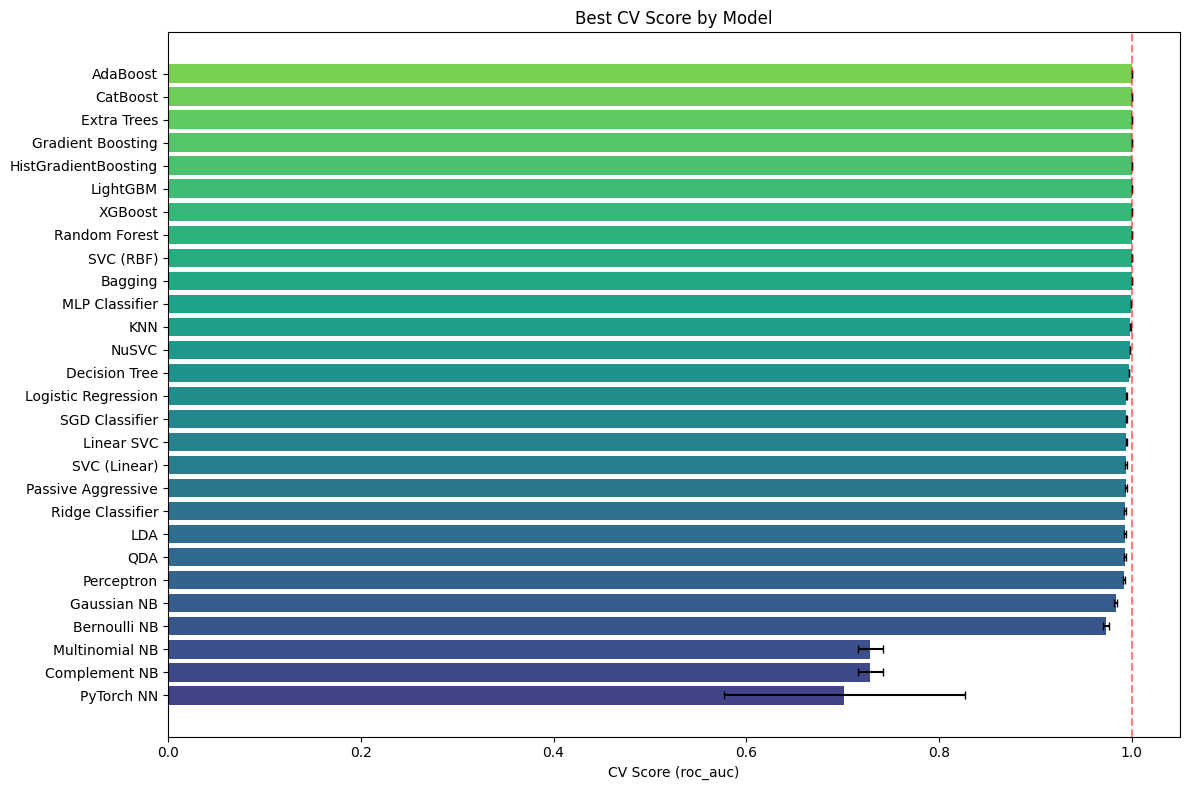

In [11]:
# --- Bar Chart: CV Scores by Model ---
fig, ax = plt.subplots(figsize=(12, 8))

# Get best score per model for cleaner visualization
plot_df = best_per_model.sort_values('CV Score', ascending=True).copy()

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(plot_df)))
bars = ax.barh(plot_df['Model'], plot_df['CV Score'], xerr=plot_df['Std'], 
               color=colors, capsize=3)

ax.set_xlabel(f'CV Score ({SCORING})')
ax.set_title('Best CV Score by Model')
ax.axvline(x=plot_df['CV Score'].max(), color='red', linestyle='--', alpha=0.5, label='Best Score')
plt.tight_layout()
plt.show()

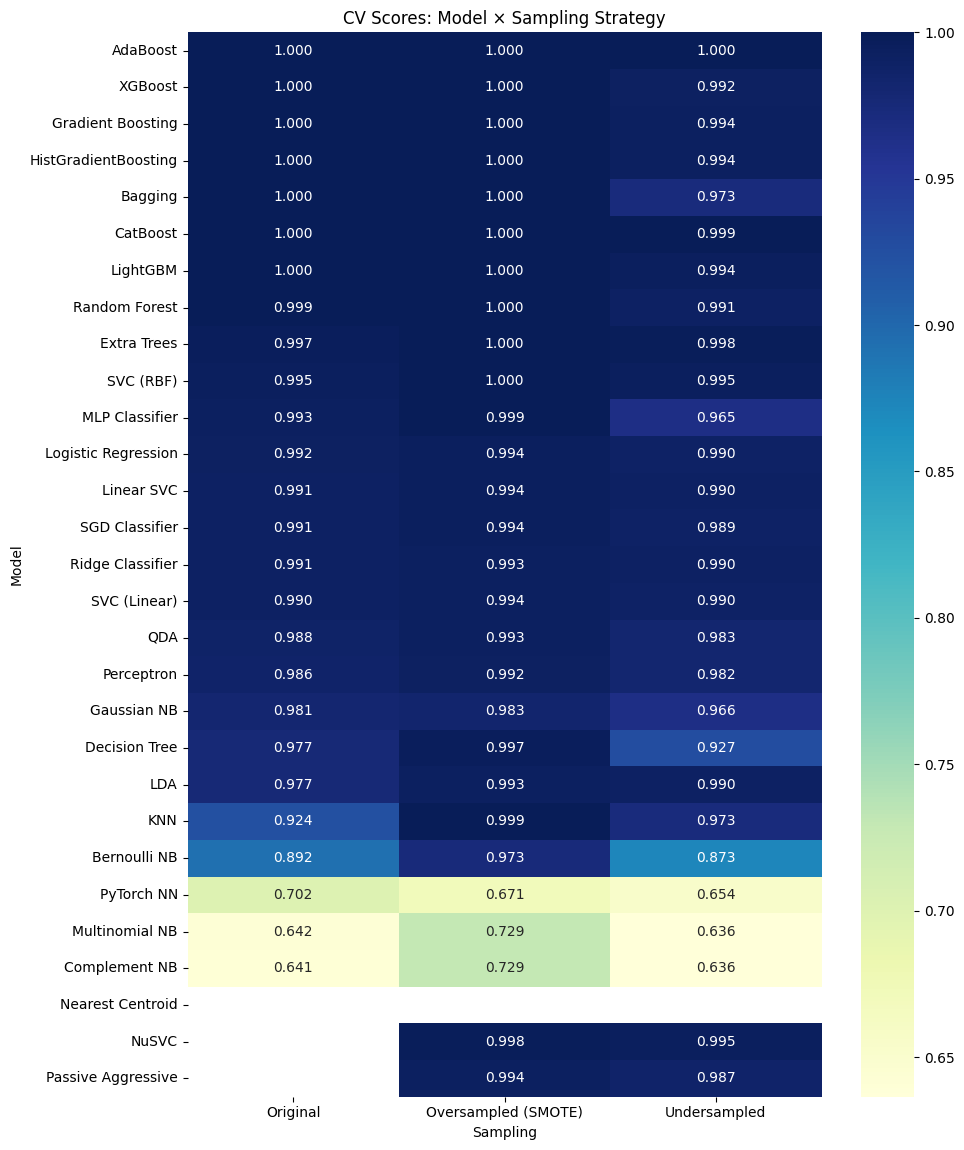

In [12]:
# --- Heatmap: Model x Sampling Strategy ---
if len(SAMPLING_STRATEGIES) > 1:
    pivot_df = results_df.pivot(index='Model', columns='Sampling', values='CV Score')
    pivot_df = pivot_df.sort_values(pivot_df.columns[0], ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, max(8, len(pivot_df) * 0.4)))
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
    ax.set_title('CV Scores: Model × Sampling Strategy')
    plt.tight_layout()
    plt.show()

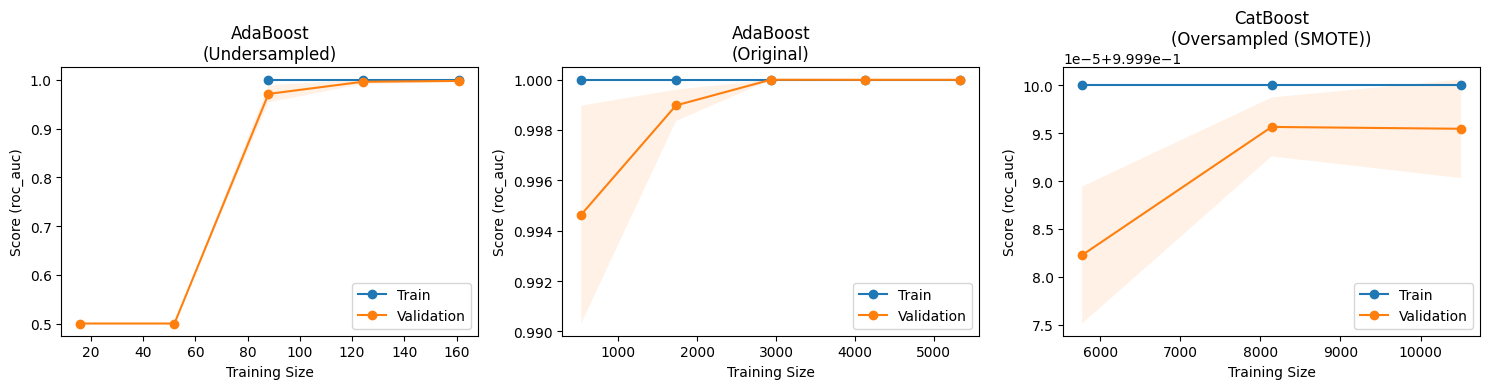

In [13]:
# --- Learning Curves for Top 3 Models ---
top_3 = results_df.head(3)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (_, row) in enumerate(top_3.iterrows()):
    model_key = f"{row['Model']}_{row['Sampling']}"
    if model_key not in best_models:
        continue
        
    model_info = best_models[model_key]
    best_estimator = model_info['search'].best_estimator_
    sampler = model_info['sampler']
    
    # Get sampled data
    if sampler is not None:
        X_sampled, y_sampled = sampler.fit_resample(X_train, y_train)
    else:
        X_sampled, y_sampled = X_train, y_train
    
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            best_estimator, X_sampled, y_sampled,
            train_sizes=np.linspace(0.1, 1.0, 5),
            cv=3, scoring=SCORING, n_jobs=-1
        )
        
        ax = axes[idx]
        ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
        ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
        ax.fill_between(train_sizes, 
                        train_scores.mean(axis=1) - train_scores.std(axis=1),
                        train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
        ax.fill_between(train_sizes,
                        val_scores.mean(axis=1) - val_scores.std(axis=1),
                        val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1)
        ax.set_xlabel('Training Size')
        ax.set_ylabel(f'Score ({SCORING})')
        ax.set_title(f"{row['Model']}\n({row['Sampling']})")
        ax.legend(loc='lower right')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Could not generate\nlearning curve", 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f"{row['Model']}")

plt.tight_layout()
plt.show()

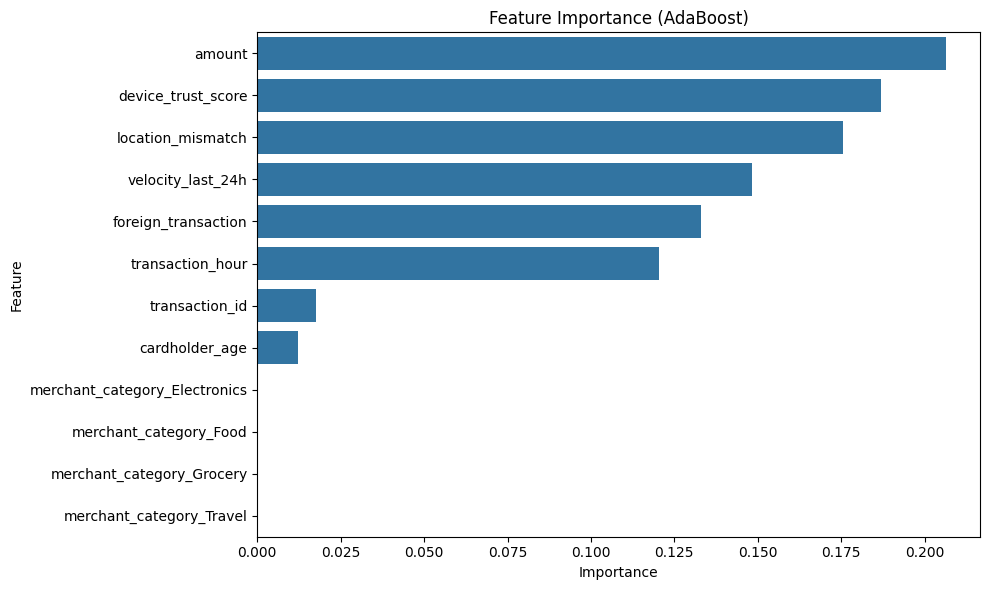

In [14]:
# --- Feature Importance (for tree-based models) ---
top_result = results_df.iloc[0]
top_key = f"{top_result['Model']}_{top_result['Sampling']}"

if top_key in best_models:
    top_estimator = best_models[top_key]['search'].best_estimator_
    
    # Get the actual model from pipeline
    if hasattr(top_estimator, 'named_steps'):
        model = top_estimator.named_steps['model']
    else:
        model = top_estimator
    
    # Check for feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feat_imp_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        top_n = min(20, len(feat_imp_df))
        sns.barplot(data=feat_imp_df.head(top_n), x='Importance', y='Feature', ax=ax)
        ax.set_title(f'Feature Importance ({top_result["Model"]})')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature importance not available for {top_result['Model']}")

---
## Section 11: Stacking Ensemble with OOF Predictions

In [15]:
# ============================================================
# BUILD STACKING ENSEMBLE FROM TOP N MODELS
# ============================================================

# Get top N unique models (best sampling strategy for each)
top_models_df = results_df.dropna(subset=['CV Score']).head(TOP_N_MODELS * 2)
seen_models = set()
top_unique = []

for _, row in top_models_df.iterrows():
    if row['Model'] not in seen_models:
        top_unique.append(row)
        seen_models.add(row['Model'])
    if len(top_unique) >= TOP_N_MODELS:
        break

print(f"Top {TOP_N_MODELS} models for stacking:")
for i, row in enumerate(top_unique):
    print(f"  {i+1}. {row['Model']} ({row['Sampling']}) - Score: {row['CV Score']:.4f}")

# Build estimator list for stacking
estimators = []
for row in top_unique:
    model_key = f"{row['Model']}_{row['Sampling']}"
    if model_key in best_models:
        best_est = best_models[model_key]['search'].best_estimator_
        # Use a clean name for the estimator
        clean_name = row['Model'].lower().replace(' ', '_').replace('(', '').replace(')', '')
        estimators.append((clean_name, best_est))

Top 3 models for stacking:
  1. AdaBoost (Undersampled) - Score: 1.0000
  2. CatBoost (Oversampled (SMOTE)) - Score: 1.0000
  3. Extra Trees (Oversampled (SMOTE)) - Score: 1.0000


In [16]:
# --- Stacking Classifier with OOF ---
if len(estimators) >= 2:
    print("\nBuilding Stacking Classifier...")
    
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        cv=CV_FOLDS,  # This uses OOF predictions internally
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # Fit stacking model
    start_time = time()
    stacking_clf.fit(X_train, y_train)
    stacking_time = time() - start_time
    
    # Cross-validate stacking model
    stacking_scores = cross_val_score(stacking_clf, X_train, y_train, cv=cv, scoring=SCORING)
    
    print(f"\nStacking Classifier Results:")
    print(f"  CV Score: {stacking_scores.mean():.4f} (+/- {stacking_scores.std():.4f})")
    print(f"  Training time: {stacking_time:.1f}s")
else:
    print("Not enough successful models for stacking.")
    stacking_clf = None


Building Stacking Classifier...

Stacking Classifier Results:
  CV Score: 0.9998 (+/- 0.0004)
  Training time: 2.9s


---
## Section 12: Optimized Blending Weights

In [17]:
# ============================================================
# OPTIMIZED BLENDING VIA SCIPY.OPTIMIZE
# ============================================================

if len(estimators) >= 2:
    print("\nComputing optimized blend weights using OOF predictions...")
    
    # Generate OOF predictions for each base model
    oof_predictions = []
    model_names_blend = []
    
    for name, est in estimators:
        try:
            # Get probability predictions via cross_val_predict
            if hasattr(est, 'predict_proba'):
                oof_proba = cross_val_predict(est, X_train, y_train, cv=cv, method='predict_proba')
                # For binary, take probability of positive class
                if oof_proba.shape[1] == 2:
                    oof_predictions.append(oof_proba[:, 1])
                else:
                    oof_predictions.append(oof_proba)
            else:
                # Use decision function or predictions
                oof_pred = cross_val_predict(est, X_train, y_train, cv=cv, method='decision_function')
                oof_predictions.append(oof_pred)
            model_names_blend.append(name)
            print(f"  Generated OOF for: {name}")
        except Exception as e:
            print(f"  Could not generate OOF for {name}: {str(e)[:40]}")
    
    if len(oof_predictions) >= 2:
        oof_array = np.column_stack(oof_predictions)
        
        # Objective function: minimize negative score (to maximize score)
        def blend_objective(weights):
            weights = np.array(weights)
            weights = weights / weights.sum()  # Normalize
            blended = np.dot(oof_array, weights)
            
            # For roc_auc scoring
            if 'roc_auc' in SCORING:
                score = roc_auc_score(y_train, blended)
            else:
                # For other metrics, threshold at 0.5
                blended_binary = (blended > 0.5).astype(int)
                score = f1_score(y_train, blended_binary, average='weighted')
            
            return -score  # Negative because we minimize
        
        # Initial weights (equal)
        n_models = len(oof_predictions)
        initial_weights = np.ones(n_models) / n_models
        
        # Constraints: weights sum to 1, all >= 0
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(n_models)]
        
        # Optimize
        result = minimize(
            blend_objective, initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        optimal_weights = result.x / result.x.sum()
        optimal_score = -result.fun
        
        print(f"\nOptimized Blend Weights:")
        print("-" * 40)
        for name, weight in zip(model_names_blend, optimal_weights):
            print(f"  {name}: {weight:.4f} ({weight*100:.1f}%)")
        print(f"\nOptimized Blend Score ({SCORING}): {optimal_score:.4f}")
        
        # Store for later use
        blend_weights = dict(zip(model_names_blend, optimal_weights))
    else:
        print("Not enough OOF predictions for blending optimization.")
        blend_weights = None
else:
    blend_weights = None


Computing optimized blend weights using OOF predictions...
  Generated OOF for: adaboost
  Generated OOF for: catboost
  Generated OOF for: extra_trees

Optimized Blend Weights:
----------------------------------------
  adaboost: 0.3333 (33.3%)
  catboost: 0.3333 (33.3%)
  extra_trees: 0.3333 (33.3%)

Optimized Blend Score (roc_auc): 0.9998


---
## Section 13: Final Holdout Evaluation

In [18]:
# ============================================================
# EVALUATE ON HOLDOUT TEST SET
# ============================================================

print("Final Holdout Test Set Evaluation")
print("=" * 60)

# Best single model
top_result = results_df.iloc[0]
top_key = f"{top_result['Model']}_{top_result['Sampling']}"

if top_key in best_models:
    top_model = best_models[top_key]['search'].best_estimator_
    
    # Predict on test set
    y_pred = top_model.predict(X_test)
    
    if hasattr(top_model, 'predict_proba'):
        y_proba = top_model.predict_proba(X_test)
        if y_proba.shape[1] == 2:
            test_auc = roc_auc_score(y_test, y_proba[:, 1])
        else:
            test_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        test_auc = np.nan
    
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nBest Single Model: {top_result['Model']} ({top_result['Sampling']})")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test F1 (weighted): {test_f1:.4f}")
    print(f"  Test ROC-AUC: {test_auc:.4f}" if not np.isnan(test_auc) else "  Test ROC-AUC: N/A")

Final Holdout Test Set Evaluation

Best Single Model: AdaBoost (Undersampled)
  Test Accuracy: 0.9820
  Test F1 (weighted): 0.9853
  Test ROC-AUC: 1.0000


In [19]:
# Stacking model evaluation
if stacking_clf is not None:
    y_pred_stack = stacking_clf.predict(X_test)
    y_proba_stack = stacking_clf.predict_proba(X_test)
    
    if y_proba_stack.shape[1] == 2:
        stack_auc = roc_auc_score(y_test, y_proba_stack[:, 1])
    else:
        stack_auc = roc_auc_score(y_test, y_proba_stack, multi_class='ovr')
    
    stack_acc = accuracy_score(y_test, y_pred_stack)
    stack_f1 = f1_score(y_test, y_pred_stack, average='weighted')
    
    print(f"\nStacking Ensemble:")
    print(f"  Test Accuracy: {stack_acc:.4f}")
    print(f"  Test F1 (weighted): {stack_f1:.4f}")
    print(f"  Test ROC-AUC: {stack_auc:.4f}")


Stacking Ensemble:
  Test Accuracy: 1.0000
  Test F1 (weighted): 1.0000
  Test ROC-AUC: 1.0000


In [28]:
# What did AdaBoost get wrong that stacking got right?
y_pred_single = best_models[top_key]['search'].best_estimator_.predict(X_test)

mask = (y_pred_single != y_test) & (y_pred_stack == y_test)
print(f"Samples AdaBoost missed but Stacking got: {mask.sum()}")
print(X_test[mask])

Samples AdaBoost missed but Stacking got: 36
      transaction_id      amount  transaction_hour  foreign_transaction  \
4024          4025.0  201.250000              16.0                  0.0   
6916          6917.0   85.860001               5.0                  1.0   
4524          4525.0  299.079987               8.0                  1.0   
5378          5379.0  298.910004              11.0                  0.0   
3319          3320.0  266.750000               4.0                  1.0   
8638          8639.0  167.889999              11.0                  0.0   
2422          2423.0  254.059998               8.0                  1.0   
9484          9485.0  413.119995               8.0                  0.0   
6788          6789.0  342.179993               4.0                  1.0   
775            776.0   29.240000              14.0                  1.0   
151            152.0   49.290001              16.0                  0.0   
1250          1251.0  286.609985              15.0     

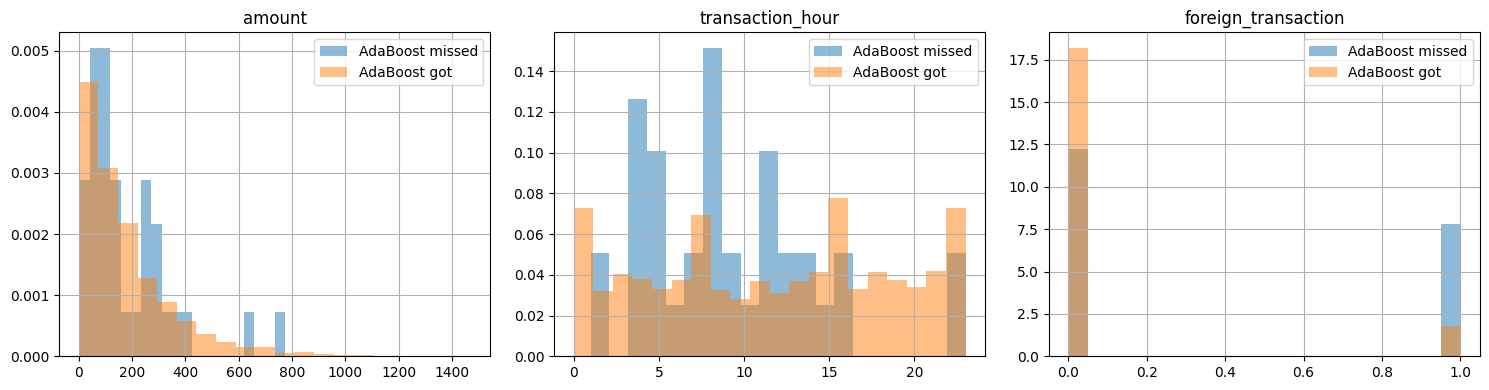

In [31]:
# Define the mask and subsets
y_pred_single = best_models[top_key]['search'].best_estimator_.predict(X_test)

mask = (y_pred_single != y_test) & (y_pred_stack == y_test)
saved = X_test[mask]
missed = X_test[~mask]

# Compare distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ['amount', 'transaction_hour', 'foreign_transaction']):
    saved[col].hist(ax=ax, alpha=0.5, label='AdaBoost missed', bins=20, density=True)
    missed[col].hist(ax=ax, alpha=0.5, label='AdaBoost got', bins=20, density=True)
    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.show()

Transaction Hour - Clear spike around hours 5-10 (morning transactions). AdaBoost struggled with this time window while stacking caught them.
Foreign Transaction - Higher proportion of foreign transactions (1.0) in the missed cases. That tall blue bar on the right is notable.
Amount - Slightly more concentrated in the low-to-mid range (0-200), but less dramatic difference.

The story: AdaBoost was missing morning foreign transactions. CatBoost (with its heavy weight in the stack) likely handles the interaction between time and foreign_transaction better.
This is exactly the kind of edge case where stacking shines - individual models have blind spots, and combining diverse learners covers them.


Stacking Ensemble Feature Importance


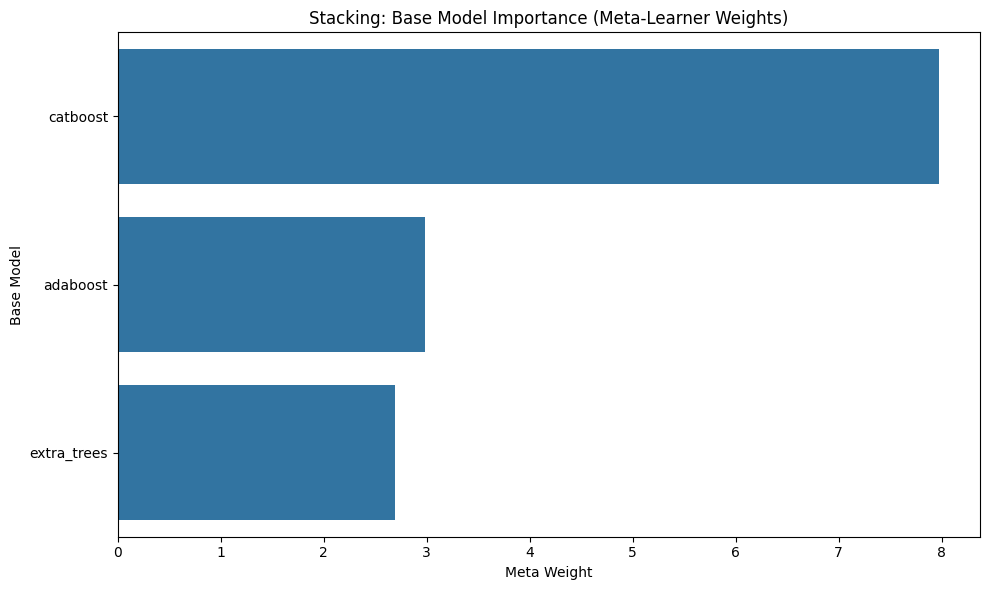


--- Aggregated Feature Importance from Base Models ---
  ✓ adaboost: has feature_importances_
  ✓ catboost: has feature_importances_
  ✓ extra_trees: has feature_importances_


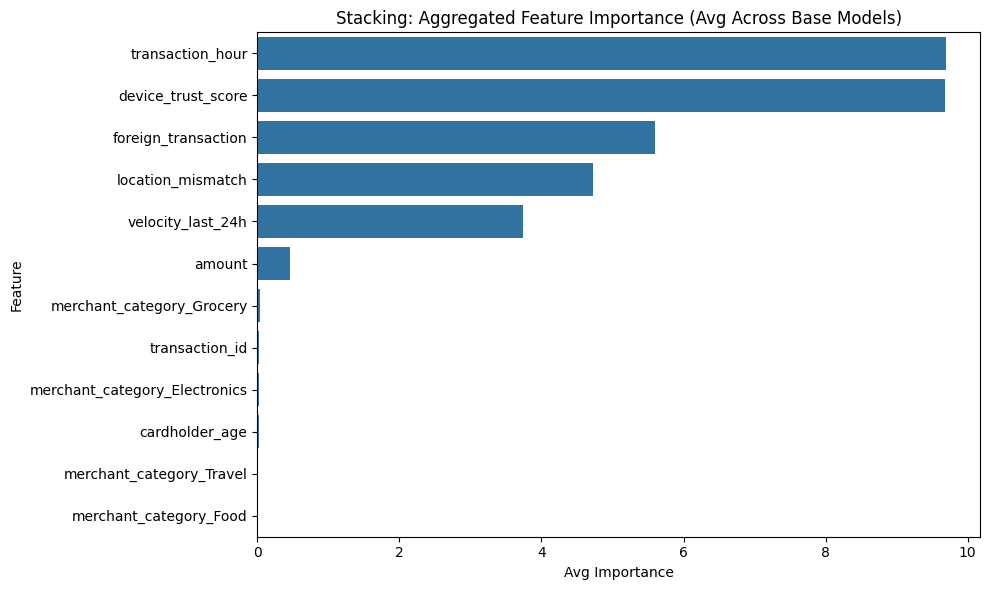

In [25]:
# --- Feature Importance for Stacking Ensemble ---
if stacking_clf is not None:
    print("\n" + "="*60)
    print("Stacking Ensemble Feature Importance")
    print("="*60)
    
    # 1. Meta-learner weights (which base models matter most)
    if hasattr(stacking_clf, 'final_estimator_'):
        meta = stacking_clf.final_estimator_
        
        if hasattr(meta, 'coef_'):
            base_names = [name for name, _ in stacking_clf.estimators]
            meta_weights = np.abs(meta.coef_).flatten()
            
            meta_imp_df = pd.DataFrame({
                'Base Model': base_names,
                'Meta Weight': meta_weights
            }).sort_values('Meta Weight', ascending=False)
            
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.barplot(data=meta_imp_df, x='Meta Weight', y='Base Model', ax=ax)
            ax.set_title('Stacking: Base Model Importance (Meta-Learner Weights)')
            plt.tight_layout()
            plt.show()
    
    # 2. Aggregated feature importance from base models
    print("\n--- Aggregated Feature Importance from Base Models ---")
    
    feature_importances = []
    
    for name, estimator in stacking_clf.named_estimators_.items():
        # Get model from pipeline if needed
        if hasattr(estimator, 'named_steps'):
            model = estimator.named_steps['model']
        else:
            model = estimator
        
        if hasattr(model, 'feature_importances_'):
            feature_importances.append({
                'name': name,
                'importance': model.feature_importances_
            })
            print(f"  ✓ {name}: has feature_importances_")
        elif hasattr(model, 'coef_'):
            feature_importances.append({
                'name': name,
                'importance': np.abs(model.coef_).flatten()
            })
            print(f"  ✓ {name}: has coef_")
        else:
            print(f"  ✗ {name}: no feature importance available")
    
    # Average importance across base models that have it
    if feature_importances:
        avg_importance = np.mean([fi['importance'] for fi in feature_importances], axis=0)
        
        agg_imp_df = pd.DataFrame({
            'Feature': X.columns,
            'Avg Importance': avg_importance
        }).sort_values('Avg Importance', ascending=False)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        top_n = min(20, len(agg_imp_df))
        sns.barplot(data=agg_imp_df.head(top_n), x='Avg Importance', y='Feature', ax=ax)
        ax.set_title('Stacking: Aggregated Feature Importance (Avg Across Base Models)')
        plt.tight_layout()
        plt.show()

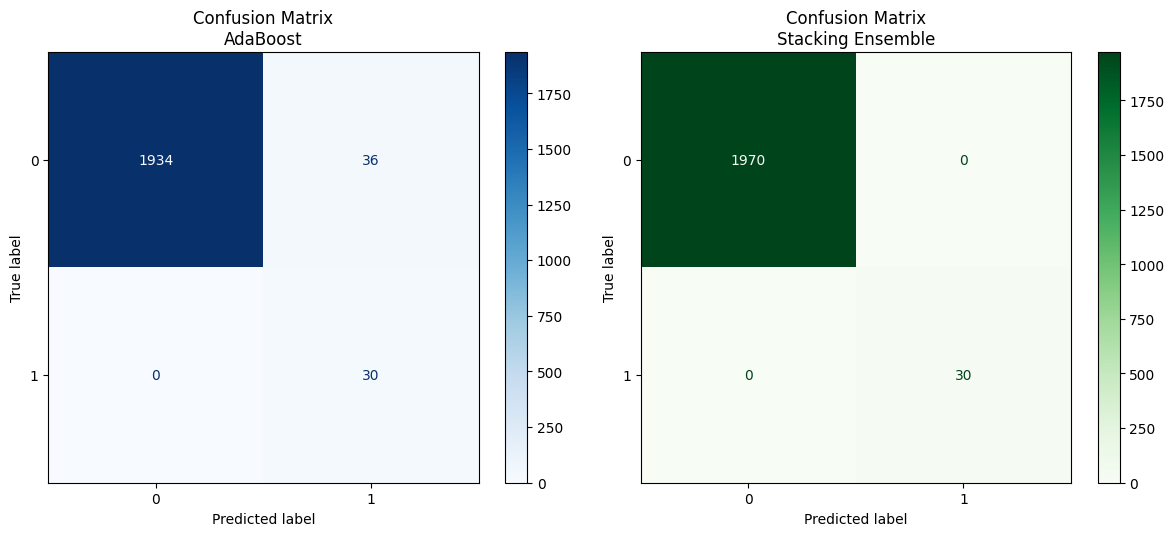

In [20]:
# --- Confusion Matrix for Best Model ---
if top_key in best_models:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Best single model
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap='Blues')
    axes[0].set_title(f'Confusion Matrix\n{top_result["Model"]}')
    
    # Stacking model
    if stacking_clf is not None:
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred_stack, ax=axes[1], cmap='Greens')
        axes[1].set_title('Confusion Matrix\nStacking Ensemble')
    else:
        axes[1].text(0.5, 0.5, 'Stacking not available', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

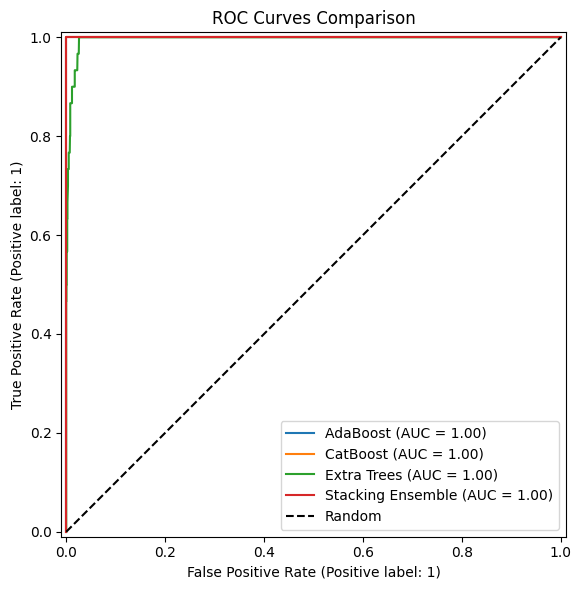

In [21]:
# --- ROC Curves (Binary Classification) ---
if n_classes == 2:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot for top 3 models + stacking
    for i, row in enumerate(top_unique[:3]):
        model_key = f"{row['Model']}_{row['Sampling']}"
        if model_key in best_models:
            est = best_models[model_key]['search'].best_estimator_
            if hasattr(est, 'predict_proba'):
                RocCurveDisplay.from_estimator(est, X_test, y_test, ax=ax, name=row['Model'])
    
    if stacking_clf is not None:
        RocCurveDisplay.from_estimator(stacking_clf, X_test, y_test, ax=ax, name='Stacking Ensemble')
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_title('ROC Curves Comparison')
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [22]:
# --- Classification Report ---
print("\nClassification Report (Best Single Model):")
print("=" * 60)
print(classification_report(y_test, y_pred))

if stacking_clf is not None:
    print("\nClassification Report (Stacking Ensemble):")
    print("=" * 60)
    print(classification_report(y_test, y_pred_stack))


Classification Report (Best Single Model):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1970
           1       0.45      1.00      0.62        30

    accuracy                           0.98      2000
   macro avg       0.73      0.99      0.81      2000
weighted avg       0.99      0.98      0.99      2000


Classification Report (Stacking Ensemble):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1970
           1       1.00      1.00      1.00        30

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



---
## Section 14: Summary & Export

In [23]:
# ============================================================
# SUMMARY
# ============================================================

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"\nDataset: {FILEPATH}")
print(f"Features: {X.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Classes: {n_classes}")

print(f"\nModels evaluated: {len(MODELS)}")
print(f"Sampling strategies: {list(SAMPLING_STRATEGIES.keys())}")
print(f"Total model runs: {len(results_df)}")

print(f"\n--- Best Single Model ---")
print(f"Model: {top_result['Model']}")
print(f"Sampling: {top_result['Sampling']}")
print(f"CV Score ({SCORING}): {top_result['CV Score']:.4f}")
print(f"Best Params: {top_result['Best Params']}")

if stacking_clf is not None:
    print(f"\n--- Stacking Ensemble ---")
    print(f"Base models: {[name for name, _ in estimators]}")
    print(f"CV Score: {stacking_scores.mean():.4f}")

if blend_weights is not None:
    print(f"\n--- Optimized Blend Weights ---")
    for name, weight in blend_weights.items():
        print(f"  {name}: {weight:.2%}")


FINAL SUMMARY

Dataset: credit_card_fraud.csv
Features: 12
Training samples: 8000
Test samples: 2000
Classes: 2

Models evaluated: 29
Sampling strategies: ['Original', 'Undersampled', 'Oversampled (SMOTE)']
Total model runs: 87

--- Best Single Model ---
Model: AdaBoost
Sampling: Undersampled
CV Score (roc_auc): 1.0000
Best Params: {'model__learning_rate': 1.0, 'model__n_estimators': 50}

--- Stacking Ensemble ---
Base models: ['adaboost', 'catboost', 'extra_trees']
CV Score: 0.9998

--- Optimized Blend Weights ---
  adaboost: 33.33%
  catboost: 33.33%
  extra_trees: 33.33%


In [24]:
# Export results to CSV
# results_df.to_csv('classification_results.csv', index=False)
# print("Results exported to 'classification_results.csv'")